# Retweet Prediction Challenge Partie 1 -  Data Analysis

In [86]:
# import package
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from PIL import Image
import pickle
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import time
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
tqdm.pandas()

/Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [87]:
# import database
df = pd.read_csv('data/train.csv')

# General Analysis on #retweet_count

In [88]:
n = df.shape[0]
n_0 = df[df["retweet_count"]==0]["id"].count()
n_1 = df.loc[(df["retweet_count"]==1) & (df["retweet_count"]<=4)]["id"].count()
n_2 = df.loc[(df["retweet_count"]>=5) & (df["retweet_count"]<=20)]["id"].count()
n_3 = df.loc[(df["retweet_count"]>=20) & (df["retweet_count"]<=100)]["id"].count()
n_4 = df.loc[(df["retweet_count"]>=100)& (df["retweet_count"]<=500)]["id"].count()
n_5 = df.loc[df["retweet_count"]>=500]["id"].count()

print("----- Retweet count -----")
print("0       :", n_0,  "{:.0%}".format(n_0/n))
print("[1,4]   :", n_1,  "{:.0%}".format(n_1/n))
print("[5,20]  :", n_1,  "{:.0%}".format(n_2/n))
print("[20,100] :", n_3,  "{:.0%}".format(n_3/n))
print("[100,500]   :", n_4,  "{:.0%}".format(n_4/n))
print("> 500    :", n_5,  "{:.0%}".format(n_5/n))

----- Retweet count -----
0       : 422803 64%
[1,4]   : 57111 9%
[5,20]  : 57111 9%
[20,100] : 38762 6%
[100,500]   : 21541 3%
> 500    : 15826 2%


* first observation: It is very rare to be retweeted many times. The number of retweetings is mostly below 20 retweetings  more than 80% of them.

In [89]:
#target variable -> 0 no retweet, 1 retweet
df = df.assign(retweet_bin=(df['retweet_count'] > 0 ).astype(int))

In [90]:
count_no_RT = len(df[df['retweet_bin']==0])
count_RT = len(df[df['retweet_bin']==1])
pct_of_no_RT = count_no_RT/(count_no_RT+count_RT)
print("percentage of no RT is", round(pct_of_no_RT*100))
pct_of_RT = count_RT/(count_no_RT+count_RT)
print("percentage of RT is", round(pct_of_RT*100))

percentage of no RT is 64
percentage of RT is 36


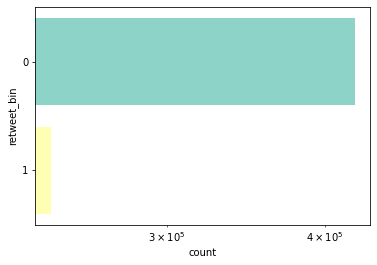

In [91]:
import seaborn as sns
sns.countplot(y='retweet_bin', data = df, palette='Set3',saturation=1,log=True )

* A tweet have two more chance to be no RT than to be retweet, even just once!

## User Feature Analysis

### User verified

In [92]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
labelencoder=LabelEncoder()
df['user_verified']=labelencoder.fit_transform(df['user_verified'])

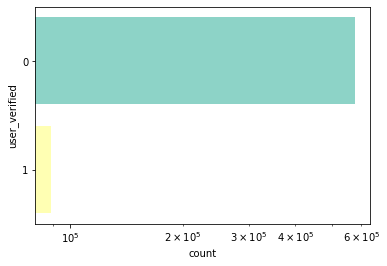

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y='user_verified', data = df, palette='Set3',saturation=1,log=True )

* We observe that the curve is very similar to the shape of the binary retweet feature! Proof that the twitter certification is correlated to the retweet number

In [95]:
# with urls --> 1, without --> 0
df['urls'] = df['urls'].fillna(0)
df = df.assign(urls=(df['urls'] !=0 ).astype(int))
# with hashtag mentions --> 1, without --> 0
df['hashtags_bin'] = df['hashtags'].fillna(0)
df = df.assign(hashtags_bin=(df['hashtags']!= 0 ).astype(int))

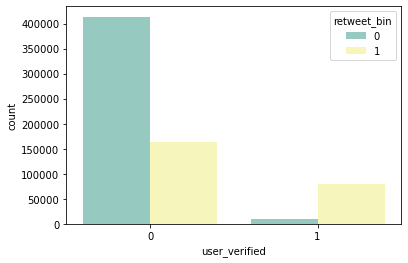

In [96]:
import seaborn as sns
sns.countplot(x='user_verified', data = df,hue ="retweet_bin", palette='Set3' )

* As we can observe when a user isn't verified, he has more chance to no't be RT than to be RT, and it's the contrary when the user is verified.

## Tweet Feature Analysis

### Hashtags

In [97]:
# number of hashtags
df['totalhashtag'] = df['hashtags'].str.split().str.len()
df['totalhashtag'] = df['totalhashtag'].fillna(0)

In [98]:
n = df.shape[0]
n_1 =  df[df["totalhashtag"]==0]["id"].count()
n_2 = df[df["totalhashtag"]==1]["id"].count()
n_3 =  df[df["totalhashtag"]==2]["id"].count()
n_4 =  df.loc[df["totalhashtag"]==3]["id"].count()
n_5 =  df.loc[df["totalhashtag"]>4]["id"].count()
print("----- Hashtags count -----")
print("0       :", n_1,  "{:.0%}".format(n_1/n))
print("1       :", n_2,  "{:.0%}".format(n_2/n))
print("2       :", n_3,  "{:.0%}".format(n_3/n))
print("3       :", n_4,  "{:.0%}".format(n_4/n))
print("<4      :", n_5,  "{:.0%}".format(n_5/n))

----- Hashtags count -----
0       : 593326 89%
1       : 42776 6%
2       : 16741 3%
3       : 6832 1%
<4      : 3150 0%


* Our analysis focused on the correlation between the number of hashtags and the fact that the tweet is retweeted. But a large majority of tweet does not contain any hashtag at 89%, so analysing the correlation was useless.

### Lenght of a tweet

In [99]:
df["length"]=df["text"].apply(lambda x : len(TextBlob(x).split(" ")))

In [100]:
def f(x):
    if (x > 0) and (x <= 7):
        return 'Short '
    elif (x > 7) and (x <= 17 ):
        return 'Medium'
    elif (x > 17):
        return'Long'

In [101]:
df['lenght_category'] = df['length'].apply(f)

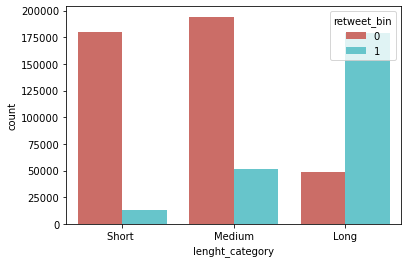

In [102]:
import seaborn as sns
sns.countplot(x='lenght_category', data = df,hue ="retweet_bin", palette='hls' )

* We have separated the classes into 3 sets of 20k data to avoid having umbalanced classes and therefore a false result. Thus we notice that the longer a tweet is, the more likely it is to be retweeted, and a short tweet is less likely to be retweeted, as it may be less insightful

## Time Feature Analysis

In [104]:
df["user_hour"] = df.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).hour)
df["user_day"] = df.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).weekday())
df["user_month"] = df.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).month)

In [107]:
## demander code a jerem

## Content Feature Analysis

### Sentiment Analysis with VADER

In [35]:
analyser = SentimentIntensityAnalyzer()
score = pd.Series(df['text']).progress_apply(lambda x: analyser.polarity_scores(x))
df['positive'] = score.apply(lambda x: x['neg'])
df['neutral'] = score.apply(lambda x: x['neu'])
df['negative'] = score.apply(lambda x: x['pos'])
df['compound'] = score.apply(lambda x: x['compound'])

In [60]:
df[['retweet_count','text', 'positive', 'negative', 'neutral', 'compound']].head()

,retweet_count,text,positive,negative,neutral,compound
665772,0,18 months dawg? Come on man...,0.000,0.000,1.000,0.0000
665773,1,Thank you to all of the nurses in our @Stanfor...,0.000,0.293,0.707,0.8070
665774,8,"'Post it' pearls for Palliative, End of Life a...",0.086,0.143,0.771,0.3818
665775,0,His facial expressions are kind of looking for...,0.000,0.000,1.000,0.0000
665776,0,We really can't wait.,0.000,0.000,1.000,0.0000


* The **Positive**, **Negative** and **Neutral** scores represent the proportion of text that falls in these categories.
* Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). It's the most interesting one.


In [49]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [45]:
sentiment_analyzer_scores("COVID-19 deaths are concentrated among the elderly and sick. Poverty and isolation will result in suicide, overdoses, domestic violence, and stress-related diseases across a span of all ages. Where is the model that justifies lockdown policy as “saving lives”? Why is it credible?")

COVID-19 deaths are concentrated among the elderly and sick. Poverty and isolation will result in suicide, overdoses, domestic violence, and stress-related diseases across a span of all ages. Where is the model that justifies lockdown policy as “saving lives”? Why is it credible? {'neg': 0.325, 'neu': 0.675, 'pos': 0.0, 'compound': -0.9599}


* Let's analyse a random tweet in our analysis. The tweet was rated as 0% Positive, 67,5% Neutral and 32,5% Negative. Hence all these should add up to 1. It is true that the negative and neutral feeling is well perceived here (no presence of upper case or punctuation but the tweet has been relatively well noted). <br> The compound score turns out to be -0.95 , denoting a very high negative sentiment.

### Top Word in a Tweet

In [69]:
# define stop words
stop_words = set(stopwords.words('english'))
# lower all cases in a tweet
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

def plot_word_cloud(text, masque, background_color = "skyblue"):
    # Définir un masque
    mask_coloring = np.array(Image.open(str(masque)))

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=400, stopwords=stop_words, mask = mask_coloring, max_font_size=120, contour_width=1, contour_color='steelblue',random_state=42, font_path='/Users/haliouanaomie/Polytechnique/INF554/font.ttf')

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (30,30))
    wc.generate(text)
    plt.imshow(wc,interpolation='bilinear')
    plt.show()

In [75]:
def plot_word_cloud(text, masque, background_color = "white") :
    # Définir un masque
    mask_coloring = np.array(Image.open(str(masque)))

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=400, mask = mask_coloring,stopwords=stop_words, max_font_size=200, random_state=42,contour_width=1, contour_color='steelblue',font_path="/Users/haliouanaomie/Polytechnique/INF554/jersey.ttf")

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (20,10))
    wc.generate(text)
    plt.imshow(wc)
    plt.show()



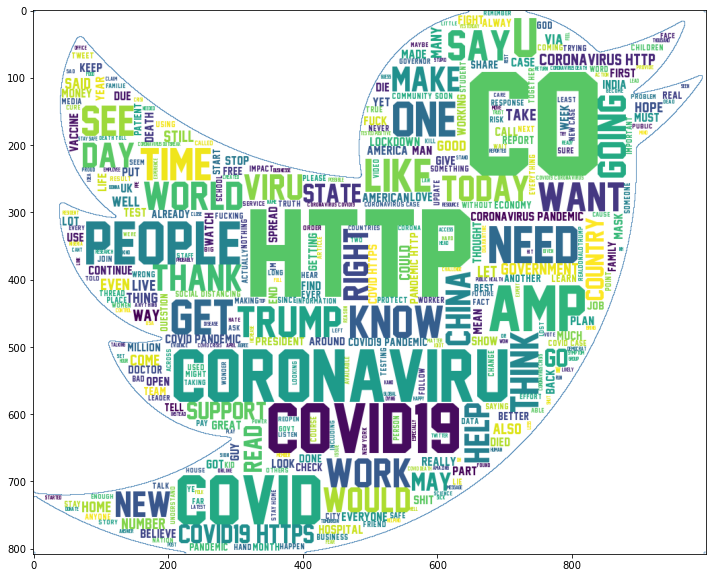

In [76]:
text_pos=''
for e in df.text :text_pos += e
plot_word_cloud(text_pos, "/Users/haliouanaomie/Polytechnique/INF554/tweet.png")

### Top Hashtag 

In [80]:
df['hashtags'] = df['hashtags'].fillna(0)
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
df = vectorizer.fit_transform(df['hashtags'].values.astype('U'))
count_df = df[df>0] = 1
sum_words = df.sum(axis=0) 

In [81]:
n = 20
common_words = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
common_words = sorted(common_words, key = lambda x: x[1], reverse=True)[:20]
    
df1 = pd.DataFrame(common_words, columns = ['Text', 'Count'])

/Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/haliouanaomie/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


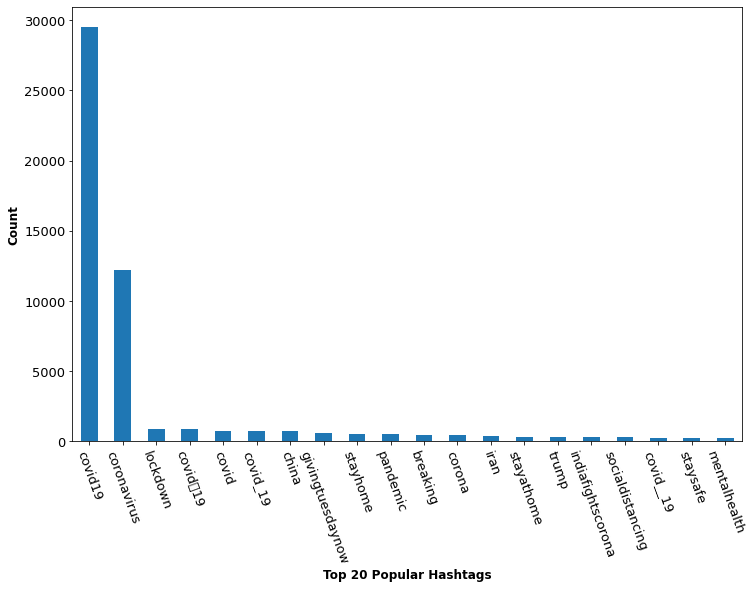

In [82]:
ax = df1.plot( x='Text', y='Count', kind='bar', legend=False, fontsize=13, rot=290, figsize=((12,8)))
ax.set_xlabel("Top 20 Popular Hashtags", fontsize=12, weight='bold')
ax.set_ylabel("Count", fontsize=12, weight='bold')
plt.show()

* the most popular hashtag is the one that speaks of covid 19 in various spellings